<a href="https://colab.research.google.com/github/uditkaushikk26/RL/blob/main/Part_3_Bandit_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *

In [8]:
# Create an Optimistic Socket class by inheriting from the standard Power Socket
class OptimisticSocket( PowerSocket ):
    def __init__( self, q, **kwargs ):

        # get the initial estimate from the kwargs
        self.initial_estimate = kwargs.pop('initial_estimate', 0.)

        # pass the true reward value to the base PowerSocket
        super().__init__(q)


    def initialize(self):
        # estimate of this socket's reward value
        # - set to supplied initial value
        self.Q = self.initial_estimate

        # the number of times this socket has been tried
        # - set to 1 if an initialisation value is supplied
        self.n = 1 if self.initial_estimate  > 0 else 0

In [9]:
# highlight the maximum value on a row
def highlight_max_row_value( row ):
    '''
    highlight the maximum value on the supplied row
    '''
    is_max = row == row.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_change_in_column( col ):
    '''
    highlight the entry before the column value changes
    '''
    style = []
    for i in range(col.shape[0]):
        if i < (col.shape[0]-1) and col.iloc[i] != col.iloc[i+1]:
            style.append('background-color: yellow')
        else:
            style.append('')
    return style

In [10]:
# Test the optimistic socket over 30 time steps
tester = SocketTester( OptimisticSocket, initial_estimate = 20.)
tester.run( number_of_steps = 30 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage():0.3f}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')

Mean Reward per Time Step = 10.98592699712126
Optimal Socket Selected = 0.724
Socket Percentages = [0.103 0.069 0.138 0.724 0.138]


In [11]:
# convert to a Pandas dataframe for table display & rename the columns to be 1-based
estimates = tester.socket_stats[:,:,0]
df = pd.DataFrame(estimates[:21])
df.columns = [1,2,3,4,5]

# show the estimates of each socket, highlighting the socket that has been selected for each time step
# - truncating to the first 20 time steps for clarity
df.style.apply(highlight_change_in_column).apply(highlight_max_row_value,axis=1,subset=df.index[-1])

,1,2,3,4,5
0,20.000000,20.000000,20.000000,20.000000,20.000000
1,20.000000,11.518804,20.000000,20.000000,20.000000
2,20.000000,11.518804,20.000000,20.000000,14.494680
3,20.000000,11.518804,20.000000,16.267202,14.494680
4,13.652844,11.518804,20.000000,16.267202,14.494680
5,13.652844,11.518804,14.590594,16.267202,14.494680
6,13.652844,11.518804,14.590594,14.748539,14.494680
7,13.652844,11.518804,14.590594,13.904598,14.494680
8,13.652844,11.518804,12.240046,13.904598,14.494680
9,13.652844,11.518804,12.240046,13.904598,13.036170


Text(0, 0.5, 'Socket Reward Estimate')

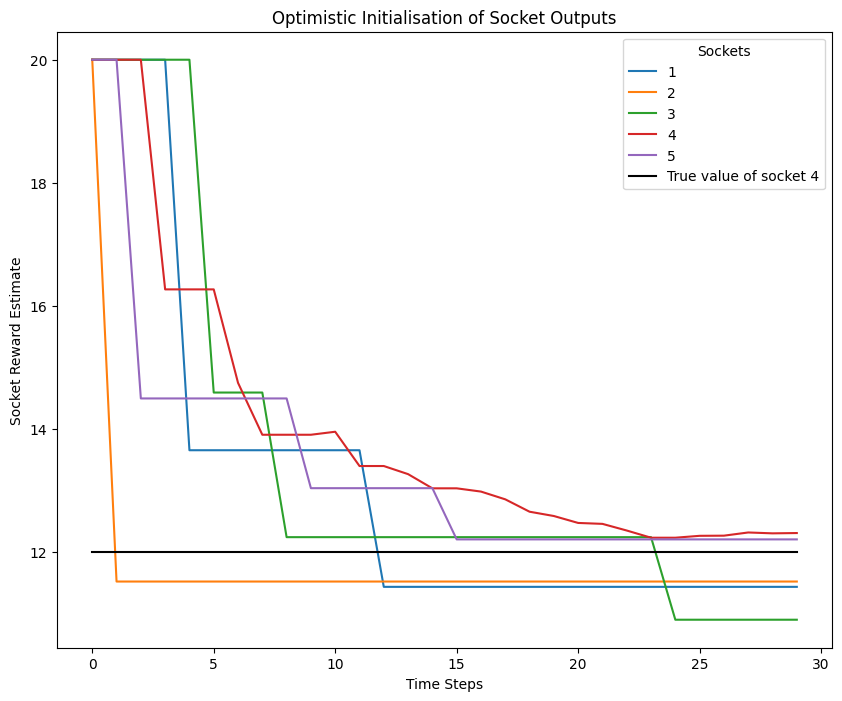

In [12]:
plt.figure(figsize=(10,8))

for socket in range(estimates.shape[1]):
    plt.plot(estimates[:30,socket], label = f'{socket+1}')

plt.plot(np.ones(30)*np.max(socket_means),'k', label = f'True value of socket 4')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation of Socket Outputs')
plt.xlabel('Time Steps')
plt.ylabel('Socket Reward Estimate')

In [13]:
def plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(10,8) ):

    plt.figure(figsize=figsize)
    plt.plot( initial_values, reward, marker='o', linestyle='--', color='r')

    # draw reference lines
    plt.plot(np.ones(max_initial_value+1)*np.max(socket_means),'k', label = f'Maximum Socket Reward')
    plt.plot(np.ones(max_initial_value+1)*np.mean(socket_means),'b', label = f'Mean Socket Reward')

    plt.legend(title = 'Key:')
    plt.title('Optimistic Initialisation: Mean Total Reward vs Initial Values')
    plt.xlabel('Initial Values')
    plt.ylabel('Mean Total Reward')

In [14]:
def run_initialisation_experiment( start, end, step = 1 ):
    """ test varying the initial estimate for optimistic-greedy """

    number_of_tests = 1000
    number_of_steps = 30
    number_of_sockets = len(socket_order)

    reward = []
    optimal_selected = []
    socket_percentages = []
    initial_values = []

    # iterate over the initial estimate values
    for initial_estimate in tqdm(range( start, (end+step), step )):

        initial_values.append( initial_estimate )

        socket_tester = SocketTester( OptimisticSocket, socket_order, initial_estimate = initial_estimate)

        socket_experiment = SocketExperiment(socket_tester = socket_tester,
                                             number_of_tests = number_of_tests,
                                             number_of_steps = number_of_steps)
        socket_experiment.run()

        reward.append( socket_experiment.get_mean_total_reward() )
        optimal_selected.append( socket_experiment.get_optimal_selected() )
        socket_percentages.append( socket_experiment.get_socket_percentages() )

    return initial_values, reward, optimal_selected, socket_percentages

100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


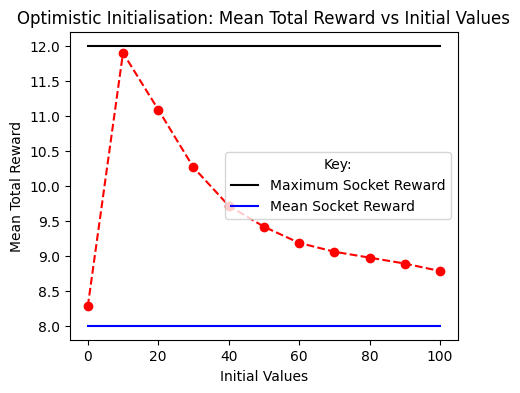

In [15]:
max_initial_value = 100
step = 10
initial_values, reward, optimal_selected, socket_percentages = run_initialisation_experiment( 0, max_initial_value, step )
plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(5,4) )

Text(0, 0.5, 'Socket Selection (%)')

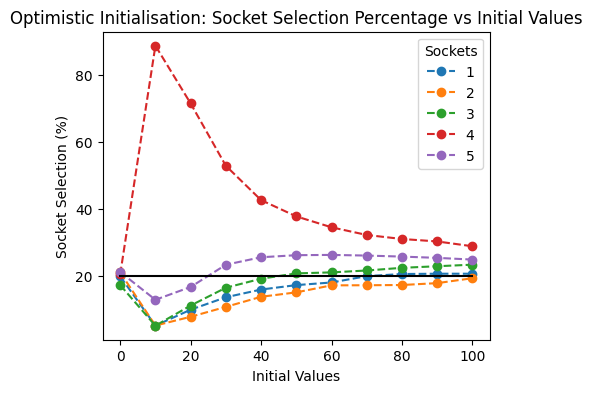

In [16]:
df = pd.DataFrame(socket_percentages)

plt.figure(figsize=(5,4))

for socket in range(df.shape[1]):
    plt.plot(initial_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')

plt.plot(initial_values, np.ones(df.shape[0])*20,'k')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation: Socket Selection Percentage vs Initial Values')
plt.xlabel('Initial Values')
plt.ylabel('Socket Selection (%)')

100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


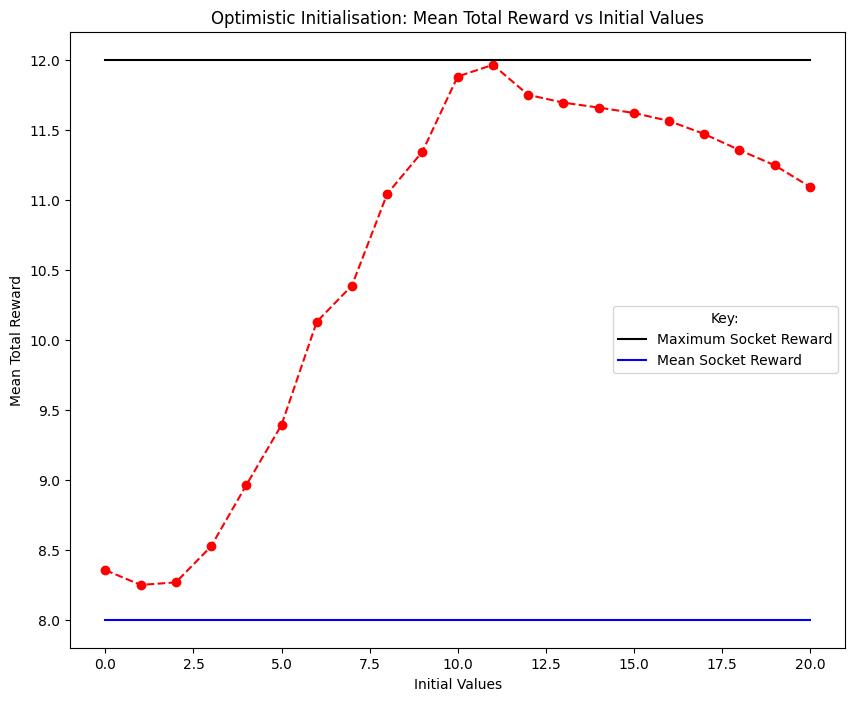

In [17]:
max_initial_value = 20
step = 1
initial_values, reward, optimal_selected, socket_percentages = run_initialisation_experiment( 0, max_initial_value, step )
plot_initial_optimisation( initial_values, reward, max_initial_value )

In [18]:
class EpsilonGreedySocketTester( SocketTester ):

    def __init__(self, epsilon = 0. ):

        # create a standard socket tester
        super().__init__()

        # save the probability of selecting the non-greedy action
        self.epsilon = epsilon


    def select_socket( self, t ):
        """ Epsilon-Greedy Socket Selection"""

        # probability of selecting a random socket
        p = np.random.random()

        # if the probability is less than epsilon then a random socket is chosen from the complete set
        if p < self.epsilon:
            socket_index = np.random.choice(self.number_of_sockets)
        else:
            # choose the socket with the current highest mean reward or arbitrary select a socket in the case of a tie
            socket_index = random_argmax([socket.sample(t) for socket in self.sockets])

        return socket_index

Looking at the graphs below, it can be seen how the value of ε affects exploration and exploitation on the socket problem:

In [19]:
# create and test epsilon-greedy sockets
tester = EpsilonGreedySocketTester( epsilon = 0.1 )
tester.run( number_of_steps = 1000 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage()}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')

Mean Reward per Time Step = 11.537811899006037
Optimal Socket Selected = 0.8768768768768769
Socket Percentages = [0.024 0.018 0.015 0.877 0.066]


In [20]:
def plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps ):

    df = pd.DataFrame(socket_percentages)
    for socket in range(df.shape[1]):
        plt.plot(epsilon_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')

    plt.plot(epsilon_values, np.ones(df.shape[0])*20,'k')

    plt.legend(title = 'Sockets')
    plt.title('Socket Selection Percentage vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Socket Selection (%)')

def plot_epsilon_greedy_final_socket_estimates( epsilon_values, final_socket_estimates, number_of_steps ):
    df = pd.DataFrame(final_socket_estimates)
    for socket in range(df.shape[1]):
        plt.plot(epsilon_values, df[socket], label = f'{socket+1}', marker='o', linestyle='--')

    plt.legend(title = 'Sockets')
    plt.title('Final Socket Estimate vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Final Socket Estimate')

def plot_epsilon_greedy_reward_per_timestep( epsilon_values, reward_per_timestep, number_of_steps, figsize=(10,8) ):

    plt.plot( epsilon_values, reward_per_timestep, marker='o', linestyle='--', color='r')
    plt.title('Mean Total Reward per Time Step vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Mean Total Reward per Time Step')


def plot_epsilon_greedy(epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps ):
    fig = plt.figure(figsize=(26,5))

    plt.suptitle(f'Epsilon Greedy: {number_of_steps} time-steps per run', fontsize=20, fontweight='bold')

    plt.subplot(1, 3, 1)
    plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps )

    plt.subplot(1, 3, 2)
    plot_epsilon_greedy_reward_per_timestep( epsilon_values, reward_per_timestep, number_of_steps )

    plt.subplot(1, 3, 3)
    plot_epsilon_greedy_final_socket_estimates( epsilon_values, final_socket_estimates, number_of_steps )

    plt.show()

In [21]:
def epsilon_greedy_experiment( number_of_tests, number_of_steps, epsilon = 0.):

    experiment = SocketExperiment(socket_tester   = EpsilonGreedySocketTester( epsilon ),
                                  number_of_tests = number_of_tests,
                                  number_of_steps = number_of_steps)
    experiment.run()

    return experiment.get_estimates(),\
           experiment.get_mean_total_reward(),\
           experiment.get_optimal_selected(),\
           experiment.get_socket_percentages()

In [22]:
def run_epsilon_greedy_experiment( start, end, step = 0.01, number_of_tests = 100, number_of_steps = 300 ):

    test_values = []
    reward_per_timestep = []
    optimal_selected = []
    socket_percentages = []
    final_socket_estimates = []

    # iterate over the epsilon values
    for epsilon in tqdm( np.arange( start, (end+step), step ) ):

        # save the test value used to run this test
        test_values.append( epsilon )

        mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = epsilon_greedy_experiment( number_of_tests, number_of_steps, epsilon )

        reward_per_timestep.append( mean_reward_per_timestep )
        optimal_selected.append( mean_optimal_selected )
        socket_percentages.append( mean_socket_percentage )
        final_socket_estimates.append( mean_estimates[-1] )

    return test_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates

100%|██████████| 21/21 [00:30<00:00,  1.43s/it]


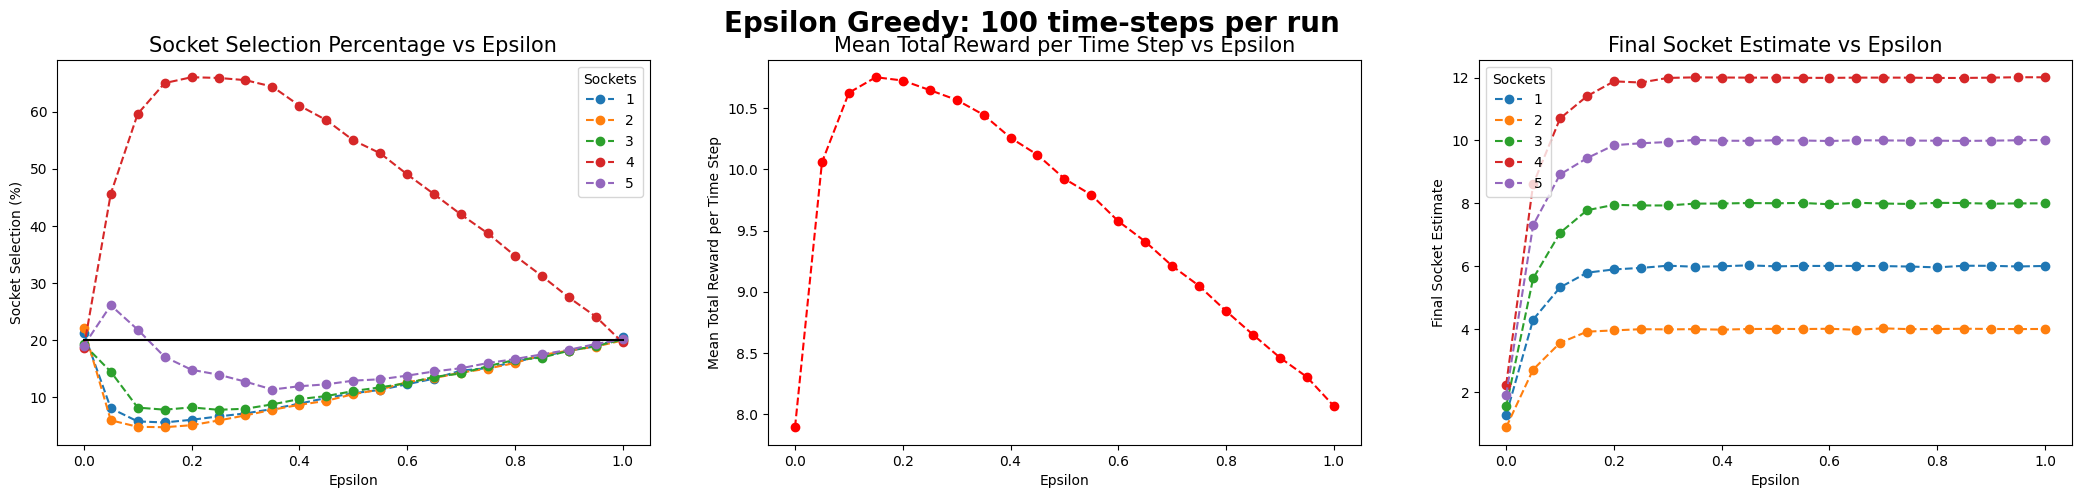

In [23]:
# how many times each test should be run
number_of_tests = 500

# the epsilon test range
start = 0
stop = 1.0
step = 0.05

number_of_steps = 100
epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = \
    run_epsilon_greedy_experiment( start, stop, step, number_of_tests, number_of_steps )

plot_epsilon_greedy(epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps )

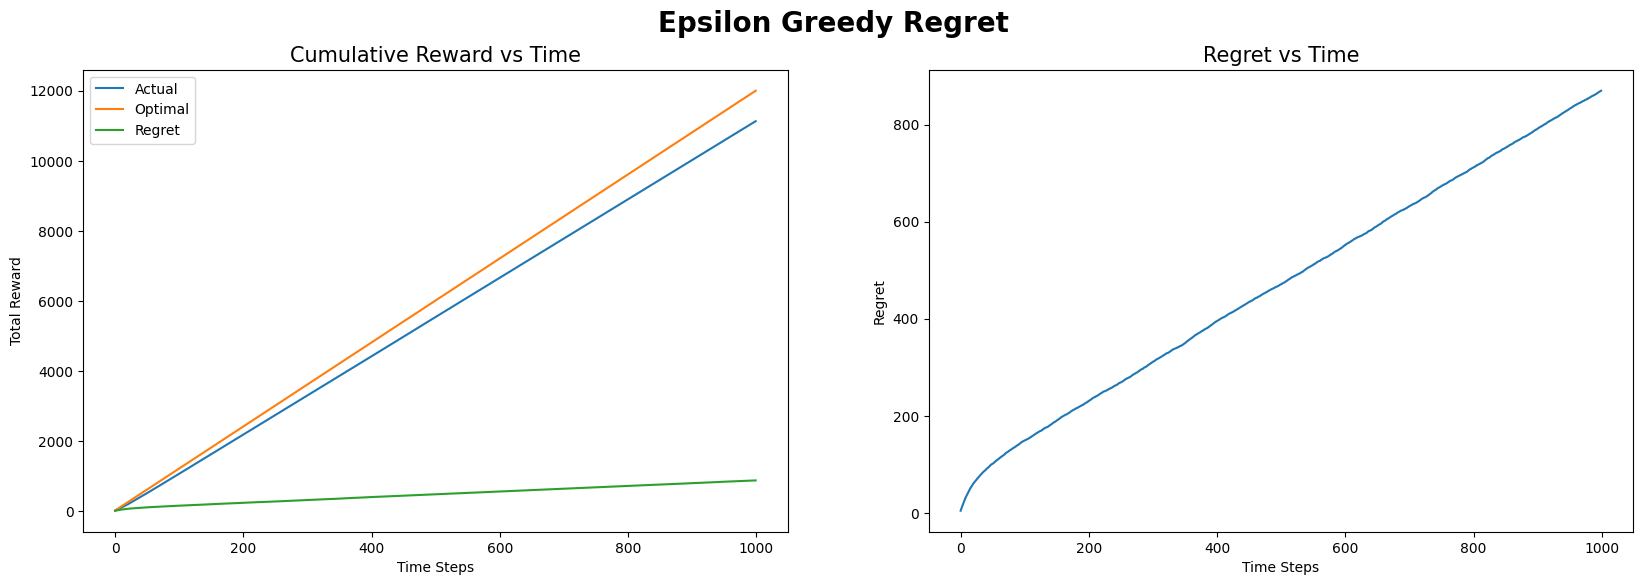

In [24]:
# run the test 100 times with each test running for 1000 timesteps
number_of_tests = 100
number_of_steps = 1000
epsilon = 0.2

experiment = SocketExperiment(socket_tester   = EpsilonGreedySocketTester( epsilon ),
                              number_of_tests = number_of_tests,
                              number_of_steps = number_of_steps)
experiment.run()


# best socket has a true mean reward of 12
cummulative_optimal_reward = [r*12 for r in range(1,number_of_steps+1)]

# regret is the difference between the optimal reward and the actual reward
regret = cummulative_optimal_reward - experiment.get_cumulative_reward_per_timestep()


fig = plt.figure(figsize=(20,6))
plt.suptitle(f'Epsilon Greedy Regret', fontsize=20, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(experiment.get_cumulative_reward_per_timestep(),label = "Actual")
plt.plot(cummulative_optimal_reward, label ="Optimal")
plt.plot(regret, label ="Regret")
plt.legend()
plt.title('Cumulative Reward vs Time', fontsize=15)
plt.xlabel('Time Steps')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.title('Regret vs Time', fontsize=15)
plt.plot(regret)
plt.xlabel('Time Steps')
plt.ylabel('Regret')

plt.show()